# xbatcher for Machine Learning Part 1

## Introduction

Here, we will be covering how to use xbatcher with Keras/Tensorflow convolutional neural network (CNN) models. 

Prerequisites:

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| Keras/Tensorflow | Strongly Recommended | Not strictly needed to understand this tutorial |

This notebook replicates the work of [Sinha and Abernathey, 2021](https://www.frontiersin.org/article/10.3389/fmars.2021.672477), where the goal is to use a CNN to learn ocean surface currents (which are usually inferred diagnostically or modelled) from variables that can be observed directly, like sea surface temperature (SST) or wind stress. 

Can we learn to predict ocean currents with just one snapshot of data?

---

### Imports

To start, let's import some libraries we'll need. The important libraries here are `numpy`, `xarray`, `xbatcher` and `tensorflow`, while most of the others aren't strictly necessary.

In [1]:
import numpy as np
import xarray as xr

from intake import open_catalog
from dataclasses import dataclass
from typing import Iterable

In [2]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
import tensorflow as tf

2023-02-28 22:58:06.691930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import xbatcher as xb

---

### Designing Scenarios

We want to experiment with different neural network models by providing different inputs, and perhaps by playing with whether or not we run them through a convolutional layer. There are a lot of possibilities here, and if we approach it haphazardly, we'll end up with a mess of scattered experiments and results mixed in with other code. 

Instead, we can be more systematic about it. We know we want to define an individual scenario once, and then have it stay constant through the workflow. This way, there will be no complexities later on about whether we're referring to the right dataset, etc. With that in mind, we should use a `dataclass`. We want something minimal here, just enough to store the names of variables we're interested in. 

What is the structure of each experiment? We want some input variables to be run through a 2D convolutional layer, while some other inputs will be passed through directly to the dense part of the neural network. Both of these can be lists of strings, so we define `conv_var` and `input_var` as `Iterable[str]`.

Likewise, we have more than one target, so we define the `target` item as `Iterable[str]` as well. Outside of the `Scenario` dataclass, we define `target` as a list: `['U', 'V']`. Since we're only interested in learning the currents, this won't change.

Finally, we need to name each scenario something distinct, so when we create data subsets for training, testing, and prediction, we can recover them later.

In [5]:
@dataclass
class Scenario:
    conv_var: Iterable[str]
    input_var: Iterable[str]
    target: Iterable[str]
    name: str

In [6]:
target = ['U', 'V']

In [7]:
sc1 = Scenario(['SSH'],             ['TAUX', 'TAUY'], target, name = "derp")
sc5 = Scenario(['SSH', 'SST'], ['X', 'TAUX', 'TAUY'], target, name = "herp")

### Data and Preprocessing

For our dataset, we will be using ocean data from a high-resolution CESM POP model. 

We have some necessary I/O routines, but they aren't central to our problem, aside from the addtion of the new variables `X`, `Y`, `Z`, `dx` and `dy`, which represent Euclidean positions and distances between grid points.

You can have a look in the notebook below if you're curious about it.

In [8]:
%run ./surface_currents_prep.ipynb

From this notebook, we get a few new functions.

  * `prepare_data` takes a scenario, as well as the time slices for training, testing, and prediction we are interested in, and the time slice we'll use for the NaN mask. It adds the new grid variables, and then stores each slice in a new zarr store that we can access later. This speeds up future I/O, which is helpful when modifying the model. Each scenario is stored separately.
  * `load_training_data` loads the training data created for the scenario passed to it.
  * `load_test_data` loads the testing data created for the scenario passed to it.
  * `load_predict_data` loads the prediction input data created for the scenario passed to it.
  
You can comment out `prepare_data` after you've run it once, it will save time if you rerun the whole notebook again.

In [9]:
prepare_data(sc5, 200, 1000, 1000, 200)

Next, we'll load our training data and pick out the part we want to train with. 

NOTE: Coordinates and attributes are dropped for speed, doing this shouldn't be necessary in future (optimized) versions of xarray/xbatcher.

In [10]:
ds_training = load_training_data(sc5)
ds_training = just_the_data(ds_training)
ds_training

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600)
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SST      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAUX     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAUY     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    U        (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    V        (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    X        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    mask     (nlat, nlon) bool dask.array<chunksize=(600, 900), meta=np.ndarray>

Looking inside `ds_training`, we see only the variables we would expect from `sc5`. 

In [11]:
ds_training = select_from(ds_training)

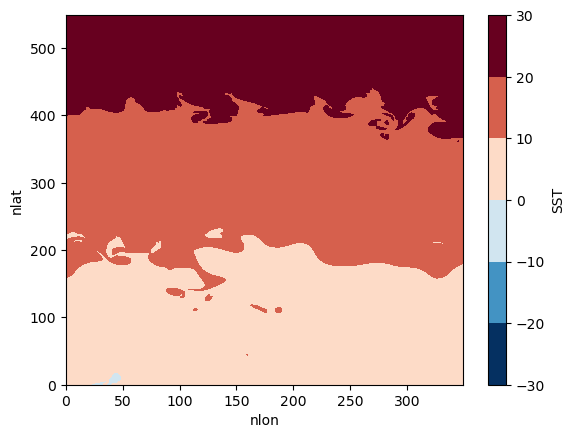

In [12]:
xr.plot.contourf(ds_training['SST'])

## Model Setup

We have a model architecuture we're happy with already defined, so for this tutorial, we'll focus on how to use xbatcher to generate training sets for the model. From the notebook below, we recieve:
  * `get_model()` Creates a mixed neural network based on some parameters. The architecture is intentionally a little arbitrary in terms of the depth of the dense part of the network, the depth of the convolutional part of the network, and the convolution kernel size. Returns a compiled Keras model.
  * `LossHistory()` Only needed here because it has to be passed to `model.fit()`.
  * `train()` We will walk through this routine below.

Have a look inside for more details!

In [13]:
%run ./surface_currents_model.ipynb

Now the fun part: we define the `train` function to deal with high-level aspects of training the model, which means this is a good place to use xbatcher. Let's walk through it...

The arguments to `train` are
  * `ds: xr.DataSet` The dataset you want to work with.
  * `sc: Scenario` The scenario you want to work with.
  * `conv_dims: List[int]` This is the shape of the stencil that will be passed to the first convolutional layer. We are only interested in 2D convolutions here, so it will need to be a list of two integers. Note that this is distinct from the convolutional kernel.
  * `nfilters: int` How many filters do we want to map the first convolution layer to?
  * `conv_kernels: List[int]` Each entry denotes the convolution kernel of a new convolution layer. `train` works best for odd-numbered convolution kernels.
  * `dense_layers: int` The number of dense layers in the model.
  
For this example, we only use one convolution layer, which makes some things simpler. Feel free to experiment with these parameters to use different data sets and create new CNN models.

In [14]:
sc = sc5
conv_dims = [5,5]
nfilters = 80
conv_kernels = [5]
dense_layers = 3

We'll need some info about how to rectify the output of the convolution layers with raw input from other variables (see the surface_currents_model.ipynb notebook for more info). Based on the convolution kernel, we know how the output of a convolution layer will be shaped compared to the input: a halo of a certain size will be removed from the edges. For odd convolution kernels, the halo thickness is always $\frac{n - 1}{2}$ where $n$ is the kernel.

In [15]:
halo_size = int((np.sum(conv_kernels) - len(conv_kernels))/2)

In [16]:
halo_size

2

## Training a Model with xbatcher

Since we are trying to learn from a single 2D snapshot, it makes sense to iterate in both latitude and longitude. What we want are individual samples of the size given by `conv_dims`, but batched in a way that we can pass the correct number of samples to the model as a single tensor. So, `input_dims` will contain entries for both `nlon` and `nlat`. To take full advantage of the available data, we can add an overlap to make sure halo points are fully included in the neighboring samples.

NOTE: xbatcher currently runs slowly with `concat_input_dims=True`, and running without it will result in batches of size one. Therefore, we use an implemenatation of xarray rolling to mimic what xbatcher does. This is not good strategy when using large datasets, but for this example, the differences are minimal. We anticipate that fixed-size batches and some optimizations will be implemented in xbatcher in the future.

In [17]:
nlons, nlats = conv_dims

In [18]:
# bgen = xb.BatchGenerator(
#     ds_training,
#     {'nlon':nlons,       'nlat':nlats},
#     {'nlon':2*halo_size, 'nlat':2*halo_size}
# )

In [19]:
latlen = len(ds_training['nlat'])
lonlen = len(ds_training['nlon'])
nlon_range = range(nlons,lonlen,nlons - 2*halo_size)
nlat_range = range(nlats,latlen,nlats - 2*halo_size)

batch = (
    ds_training
    .rolling({"nlat": nlats, "nlon": nlons})
    .construct({"nlat": "nlat_input", "nlon": "nlon_input"})[{'nlat':nlat_range, 'nlon':nlon_range}]
    .stack({"input_batch": ("nlat", "nlon")}, create_index=False)
    .rename_dims({'nlat_input':'nlat', 'nlon_input':'nlon'})
    .transpose('input_batch',...)
    # .chunk({'input_batch':32, 'nlat':nlats, 'nlon':nlons})
    .dropna('input_batch')
)

In [20]:
rnds = list(range(len(batch['input_batch'])))
np.random.shuffle(rnds)

In [21]:
batch = batch[{'input_batch':(rnds)}]
batch

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 27985 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (input_batch: 188025, nlat: 5, nlon: 5)
Dimensions without coordinates: input_batch, nlat, nlon
Data variables:
    SSH      (input_batch, nlat, nlon) float32 dask.array<chunksize=(188025, 5, 5), meta=np.ndarray>
    SST      (input_batch, nlat, nlon) float32 dask.array<chunksize=(188025, 5, 5), meta=np.ndarray>
    TAUX     (input_batch, nlat, nlon) float32 dask.array<chunksize=(188025, 5, 5), meta=np.ndarray>
    TAUY     (input_batch, nlat, nlon) float32 dask.array<chunksize=(188025, 5, 5), meta=np.ndarray>
    U        (input_batch, nlat, nlon) float32 dask.array<chunksize=(188025, 5, 5), meta=np.ndarray>
    V        (input_batch, nlat, nlon) float32 dask.array<chunksize=(188025, 5, 5), meta=np.ndarray>
    X        (input_batch, nlat, nlon) float64 dask.array<chunksize=(188025, 5, 5), meta=np.ndarray>
    mask     (input_batch, nlat, nlon) object dask.array<chunksize=(9, 5, 5), meta=np.ndarray>

In [22]:
# use with rolling
def batch_generator(batch_set, batch_size):
    n = 0
    while n < len(batch_set['input_batch']) - batch_size:
        yield batch_set.isel({'input_batch':range(n,(n+batch_size))})
        n += batch_size
        
# # use with xbatcher
# def batch_generator(bgen, batch_size):
#     b = (batch for batch in bgen)
#     n = 0
#     while n < 400:
#         batch_stack = [ next(b) for i in range(batch_size) ]
#         yield xr.concat(batch_stack, 'sample')
#         n += 1

In [23]:
bgen = batch_generator(batch, 4096)
# bgen = batch_generator(bgen, 32)

We need a subsetting stencil (`sub`) to compensate for the fact that a halo is removed by each convolution layer. This means that the input_var variables will be the wrong size at the concat layer unless we strip the halo from them.

In [24]:
sub = {'nlon':range(halo_size,nlons-halo_size),
       'nlat':range(halo_size,nlats-halo_size)}

Here, we generate our model and our history callback.

In [25]:
model = get_model(halo_size, ds_training, sc, conv_dims, nfilters, conv_kernels, dense_layers)
history = LossHistory()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 5, 2)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 1, 80)     4080        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1, 3)]    0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 1, 1, 83)     0           ['conv2d[0][0]',                 
                                                                  'input_2[0][0]']            

2023-02-28 22:59:01.836017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/nvidia/lib64
2023-02-28 22:59:01.836070: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


And now, we can construct our training loop. Most use cases of the `xb.BatchGenerator` will take the form of a for-loop with the construct `for batch in bgen`.

Once we have a batch, we still have some things to do before we can pass the data to the model.

So when we look at the contents of each batch, we see

In [26]:
# a = []
# for batch in bgen:
#     a = batch
#     break
# a

...but our model expects tensors where the different variables are stacked in a new dimension we will call `var`. 

Looking at `model.fit()`, we have two separate inputs because of the distinction between convolved inputs and raw inputs. Therefore, the model expects these inputs to be given as a list of the two. The training target is relatively straightforward. On the next line, we have a couple of parameters we can experiment with. The important thing to note is the `batch_size` parameter; you may need to check that the sample dimension is compatible with the dimensions that `xb.BatchGenerator` returned. And finally, we pass our history class as a callback so we can see how the model training is progressing.

MAE: 2.865675687789917 		 MSE: 14.63357925415039 		 Accuracy: 0.9307851195335388


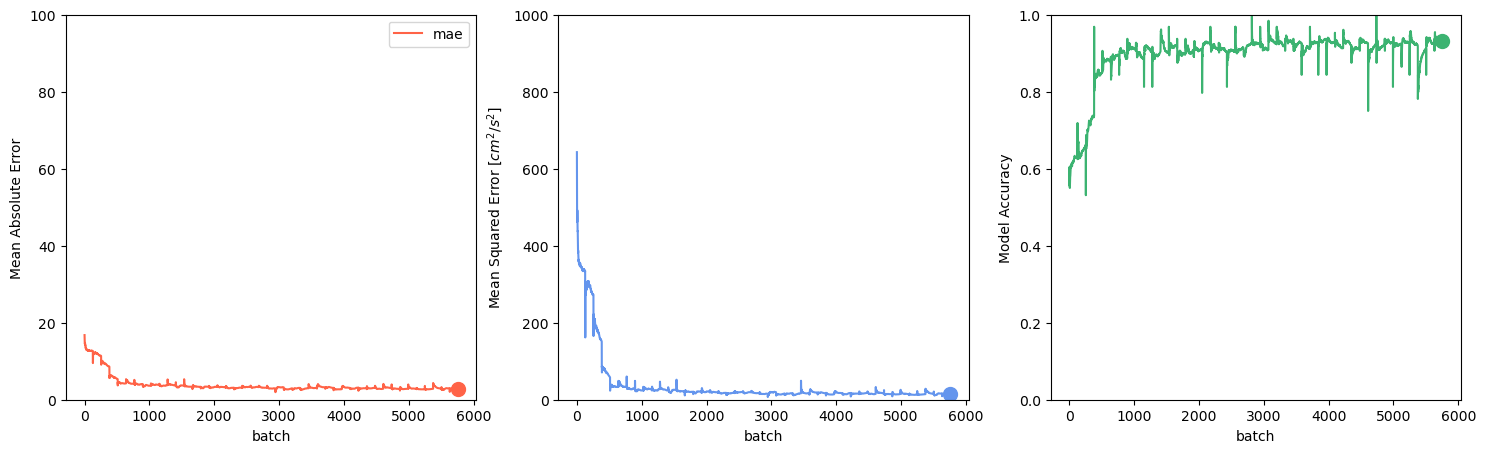

In [27]:
for batch in bgen:
    
    batch_conv   = [batch[x] for x in sc.conv_var]
    batch_input  = [batch[x][sub] for x in sc.input_var]
    batch_target = [batch[x][sub] for x in sc.target]
    batch_conv   = xr.merge(batch_conv).to_array('var').transpose(...,'var')
    batch_input  = xr.merge(batch_input).to_array('var').transpose(...,'var')
    batch_target = xr.merge(batch_target).to_array('var').transpose(...,'var')

    #clear_output(wait=True)
    model.fit([batch_conv, batch_input],
              batch_target,
              batch_size=32, verbose=0,# epochs=4,
              callbacks=[history])

And now that we have our model trained, we can save it for future use. Note that once this model is saved, we don't need to rerun much from above to continue with testing or prediction.

In [28]:
model.save('models/'+ sc.name)
np.savez('models/history_'+sc.name, losses=history.mae, mse=history.mse, accuracy=history.accuracy)

INFO:tensorflow:Assets written to: models/herp/assets


INFO:tensorflow:Assets written to: models/herp/assets


## Training Function

In [29]:
#train(ds_training, sc5, conv_dims, conv_kernels)

---

## Testing the Model

In [30]:
ds_test = load_test_data(sc5)
ds_test = just_the_data(ds_test)
ds_test = select_from(ds_test)
ds_test

<xarray.Dataset>
Dimensions:  (nlat: 550, nlon: 350)
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    SST      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUX     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUY     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    U        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    V        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    X        (nlat, nlon) float64 dask.array<chunksize=(550, 350), meta=np.ndarray>
    mask     (nlat, nlon) bool dask.array<chunksize=(100, 350), meta=np.ndarray>

In [31]:
latlen = len(ds_test['nlat'])
lonlen = len(ds_test['nlon'])
nlon_range = range(nlons,lonlen,nlons - 2*halo_size)
nlat_range = range(nlats,latlen,nlats - 2*halo_size)

batch_test = (
    ds_test
    .rolling({"nlat": nlats, "nlon": nlons})
    .construct({"nlat": "nlat_input", "nlon": "nlon_input"})[{'nlat':nlat_range, 'nlon':nlon_range}]
    .stack({"input_batch": ("nlat", "nlon")}, create_index=False)
    .rename_dims({'nlat_input':'nlat', 'nlon_input':'nlon'})
    .transpose('input_batch',...)
    # .chunk({'input_batch':32, 'nlat':nlats, 'nlon':nlons})
    .dropna('input_batch')
)

Let's load the trained model from before:

In [32]:
model = tf.keras.models.load_model('models/'+ sc.name, custom_objects={'Grid_MAE':Grid_MAE})

In [33]:
test_conv   = [batch_test[x]      for x in sc.conv_var]
test_input  = [batch_test[x][sub] for x in sc.input_var]
test_target = [batch_test[x][sub] for x in sc.target]
test_conv   = xr.merge(test_conv  ).to_array('var').transpose(...,'var')
test_input  = xr.merge(test_input ).to_array('var').transpose(...,'var')
test_target = xr.merge(test_target).to_array('var').transpose(...,'var')

In [34]:
model.evaluate([test_conv, test_input], test_target)

5876/5876 [==============================] - 908s 154ms/step - loss: 176.5244 - mae: 2.7585 - mse: 16.9111 - accuracy: 0.9345


[176.52435302734375, 2.758485794067383, 16.91105842590332, 0.9345299601554871]

## Testing Function

In [35]:
#test(ds_test, sc5, conv_dims, conv_kernels)

---

## Making Predictions

In [36]:
ds_predict = load_predict_data(sc5)
ds_predict = just_the_data(ds_predict)
ds_predict = select_from(ds_predict)
ds_predict

<xarray.Dataset>
Dimensions:  (nlat: 550, nlon: 350)
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    SST      (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUX     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    TAUY     (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    U        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    V        (nlat, nlon) float32 dask.array<chunksize=(550, 350), meta=np.ndarray>
    X        (nlat, nlon) float64 dask.array<chunksize=(550, 350), meta=np.ndarray>
    mask     (nlat, nlon) bool dask.array<chunksize=(100, 350), meta=np.ndarray>

In [37]:
latlen = len(ds_predict['nlat'])
lonlen = len(ds_predict['nlon'])
nlon_range = range(nlons,lonlen,nlons - 2*halo_size)
nlat_range = range(nlats,latlen,nlats - 2*halo_size)

batch_predict = (
    ds_predict
    .rolling({"nlat": nlats, "nlon": nlons})
    .construct({"nlat": "nlat_input", "nlon": "nlon_input"})[{'nlat':nlat_range, 'nlon':nlon_range}]
    .stack({"input_batch": ("nlat", "nlon")}, create_index=False)
    .rename_dims({'nlat_input':'nlat', 'nlon_input':'nlon'})
    .transpose('input_batch',...)
    # .chunk({'input_batch':32, 'nlat':nlats, 'nlon':nlons})
    .dropna('input_batch')
)

In [38]:
model = tf.keras.models.load_model('models/'+ sc.name, custom_objects={'Grid_MAE':Grid_MAE})

In [39]:
predict_conv  = [batch_test[x]      for x in sc.conv_var]
predict_input = [batch_test[x][sub] for x in sc.input_var]
predict_conv  = xr.merge(predict_conv ).to_array('var').transpose(...,'var')
predict_input = xr.merge(predict_input).to_array('var').transpose(...,'var')

In [40]:
predict_target = model.predict([predict_conv, predict_input])

5876/5876 [==============================] - 652s 111ms/step


## Prediction Function

In [41]:
#predict_target = predict(ds_predict, sc5, conv_dims, conv_kernels)

---

## Prediction Results

Now, let's take a look at the predicted surface currents and see how the model did. Notice that the predicted data can be retrieved fairly easily from our default setup. We only have to reshape them, with respect to the original dimensions and a halo that will be stripped off. This is because we chose to make the convolution kernel equal to the dimensions of the samples, which means the model will give results at individual points. 

However, the convolution kernal can be different, it's just that we will then have to use a more complex process to restructure our grid.

Note also that if there were nans removed, we would have to keep track of how to map the unstructured model inputs back to the original grid and insert nans in the correct positions.

In [42]:
U = ds_predict['U']
V = ds_predict['V']

In [43]:
U_pred = predict_target[:,0,0,0].reshape(545, 345)
V_pred = predict_target[:,0,0,1].reshape(545, 345)

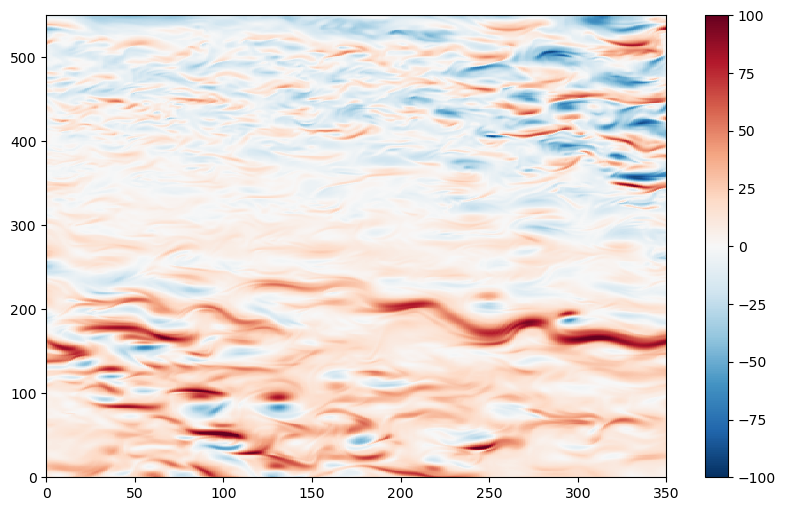

In [44]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(U, cmap='RdBu_r')
plt.clim([-100, 100])
plt.colorbar()

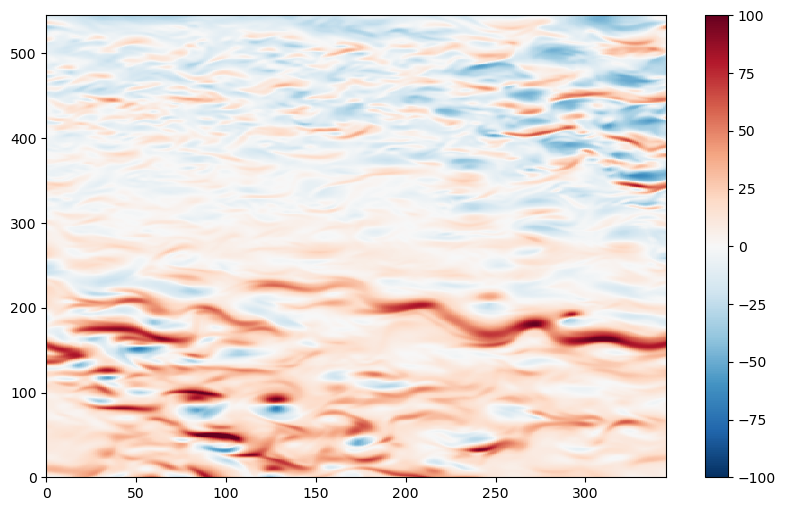

In [45]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(U_pred, cmap='RdBu_r')
plt.clim([-100, 100])
plt.colorbar()

We can see that they look very similar, but to get a better idea of what our errors look like, we can subtract them.

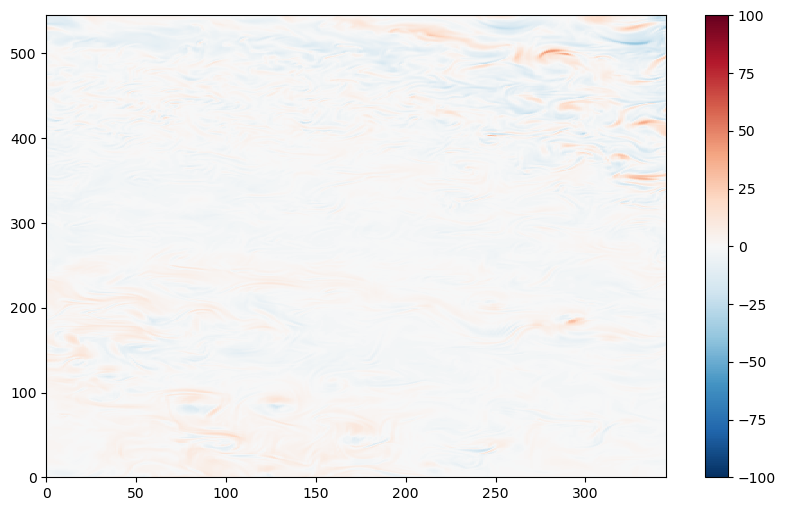

In [46]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(U_pred - U[3:-2,3:-2], cmap='RdBu_r') # double-check U indexing
plt.clim([-100, 100])
plt.colorbar()